In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
import keras 

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D, LocallyConnected2D, BatchNormalization

np.random.seed(42)
tf.random.set_seed(42)

from getdata import *

In [6]:
import mlflow
from config import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/55', experiment_id='55', lifecycle_stage='active', name='alzbusters_2D_CNN_MRI', tags={}>

In [15]:
#for dim in range(3):
N=2
d=2
dim=2
m=None
mlflow.start_run(run_name='VGG16+loccon')
mlflow.log_params({"N": N})
mlflow.log_params({"d": d})
mlflow.log_params({"dim": dim})
mlflow.log_params({"m": m})
mlflow.set_tag("Dataset", 'both')
mlflow.tensorflow.autolog()

X_train, X_test, y_train, y_test = get_tts(dim=dim, N=N, d=d, m=m)

HEIGHT = X_train.shape[1]
WIDTH = X_train.shape[2]

INPUT_SHAPE = (HEIGHT, WIDTH, 3)
b_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

for layer in b_model.layers:
    layer.trainable=False

model = Sequential()
model.add(InputLayer(input_shape=INPUT_SHAPE))
model.add(b_model)
model.add(BatchNormalization())
model.add(LocallyConnected2D(4, 3, 1))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation="sigmoid"))

# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.00001,
    decay_steps=10000,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

with tf.device('/device:GPU:0'):
  model_history = model.fit(X_train, y_train, epochs=200, shuffle=True, validation_data=(X_test, y_test), callbacks=callback)

model.save('axis0'+str(dim))
y_predd = model.predict(X_test)
y_pred = (y_predd>0.5).astype(int)

print('accuracy: ', accuracy_score(y_test, y_pred.round()).round(2))

mlflow.log_metric("test" + "-" + "acc", accuracy_score(y_test, y_pred.round()).round(2))
mlflow.log_metric("test" + "-" + "recall", recall_score(y_test, y_pred.round()).round(2))
mlflow.log_metric("test" + "-" + "precision", precision_score(y_test, y_pred.round()).round(2))
mlflow.end_run()

Epoch 1/200
149/149 [==============================] - 11s 67ms/step - loss: 6.4824 - accuracy: 0.6924 - val_loss: 6.3342 - val_accuracy: 0.7476
Epoch 2/200
149/149 [==============================] - 10s 64ms/step - loss: 6.1180 - accuracy: 0.7434 - val_loss: 6.0123 - val_accuracy: 0.7571
Epoch 3/200
149/149 [==============================] - 10s 64ms/step - loss: 5.8337 - accuracy: 0.7640 - val_loss: 5.7493 - val_accuracy: 0.7508
Epoch 4/200
149/149 [==============================] - 10s 64ms/step - loss: 5.5840 - accuracy: 0.7737 - val_loss: 5.5215 - val_accuracy: 0.7508
Epoch 5/200
 42/149 [=======>......................] - ETA: 6s - loss: 5.4311 - accuracy: 0.7820

2022/09/01 08:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


KeyboardInterrupt: ignored

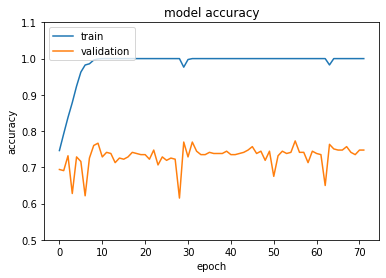

In [5]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0.5,1.1])
plt.show()

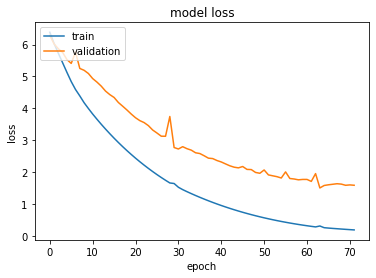

In [6]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.ylim([0.5,1.1])
plt.show()

accuracy:  0.75
recall:  0.89
precision:  0.72


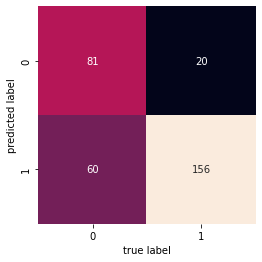

In [16]:
y_predd = model.predict(X_test)
y_pred = (y_predd>0.5).astype(int)

# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))